In [ ]:
import torch
import torch.nn as nn

class Tiny10(nn.Module):
    def __init__(self, num_classes=10):
        super(Tiny10, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



In [ ]:
import torch
import torchvision.models as models



In [ ]:
if torch.cuda.is_available():
     torch.set_default_tensor_type(torch.cuda.FloatTensor)
     print('yes')

yes


In [ ]:
import torch.nn as nn

# Modify the classifier for CIFAR-10
ft = models.resnet18(pretrained=True)
num_classes = 10
ft.fc = nn.Linear(ft.fc.in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0,  generator=torch.Generator(device='cuda'),)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=0,  generator=torch.Generator(device='cuda'),)

ft = ft.to(device)


100%|██████████| 170498071/170498071 [00:14<00:00, 12109445.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
from torchvision.utils import flow_to_image
#train classifier

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ft.parameters(), lr=0.001)
# TODO: cosine scheduler for lr
num_epochs = 4

for epoch in range(num_epochs):
    ft.train()  # Set model to training mode

    running_loss = 0.0

    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = ft(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}")
            running_loss = 0.0

    # Validation
    ft.eval()  # Set model to evaluation mode

    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = ft(images)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    accuracy_teacher = 100 * total_correct / total_samples
    print(f"Accuracy on the test set: {accuracy_teacher:.2f}%")

# End of training loop


[Epoch 1, Batch 100] Loss: 1.387
[Epoch 1, Batch 200] Loss: 1.023
[Epoch 1, Batch 300] Loss: 0.913
Accuracy on the test set: 71.76%
[Epoch 2, Batch 100] Loss: 0.783


KeyboardInterrupt: ignored

In [ ]:
pt = models.resnet18(weights=True)
pt.fc = nn.Linear(pt.fc.in_features, num_classes)
pt1 = models.resnet18(weights=True)
pt1.fc = nn.Linear(pt1.fc.in_features, num_classes)
pt2 = models.resnet18(weights=True)
pt2.fc = nn.Linear(pt2.fc.in_features, num_classes)


In [ ]:
def unbiased_HSIC(K, L):
  '''Computes an unbiased estimator of HISC. This is equation (2) from the paper'''

  # n = K.shape[0]
  # ones = np.ones(shape=(n))

  # np.fill_diagonal(K, val=0) #this is now K_tilde
  # np.fill_diagonal(L, val=0) #this is now L_tilde

  # trace = np.trace(np.dot(K, L))

  # nominator1 = np.dot(np.dot(ones.T, K), ones)
  # nominator2 = np.dot(np.dot(ones.T, L), ones)
  # denominator = (n-1)*(n-2)
  # middle = np.dot(nominator1, nominator2) / denominator


  # multiplier1 = 2/(n-2)
  # multiplier2 = np.dot(np.dot(ones.T, K), np.dot(L, ones))
  # last = multiplier1 * multiplier2

  # unbiased_hsic = 1/(n*(n-3)) * (trace + middle - last)


  ##### torch version
  n = K.shape[0]
  ones = torch.ones((n,1))

  k_t = K.fill_diagonal_(0) #this is now K_tilde
  l_t = L.fill_diagonal_(0) #this is now L_tilde

  temp = torch.matmul(k_t.clone(), l_t.clone())

  trace = torch.trace(temp)

  nominator1 = torch.matmul(torch.matmul(torch.reshape(ones,(1,-1)), k_t), ones)

  nominator2 = torch.matmul(torch.matmul(torch.reshape(ones,(1,-1)), l_t), ones)

  denominator = (n-1)*(n-2)
  middle = torch.matmul(nominator1, nominator2) / denominator


  multiplier1 = 2/(n-2)
  multiplier2 = torch.matmul(torch.matmul(torch.reshape(ones,(1,-1)), temp),  ones)
  last = multiplier1 * multiplier2

  unbiased_hsic = 1/(n*(n-3)) * (trace + middle - last)

  return unbiased_hsic

In [ ]:
def get_dcka(k, k0):
  vec_k = torch.flatten(k)
  vec_k0 = torch.flatten(k0)
  alpha = torch.dot(vec_k0, vec_k)/torch.dot(vec_k0, vec_k0)
  dk = k - alpha * k0
  u, l, v = torch.svd(dk)
  s = torch.sum(l)
  l_p = torch.where(l > 0, l, 0.)
  s_p = torch.sum(l_p)
  ro = s/s_p


  return ro*ro*torch.matmul(torch.matmul(u, torch.diag(l_p)), torch.transpose(v, 0, 1))

In [ ]:
def CKA_unbiased(X, Y, f, k0, use_dcka):

  # nominator = unbiased_HSIC(np.dot(X, X.T), np.dot(Y, Y.T))
  # denominator1 = unbiased_HSIC(np.dot(X, X.T), np.dot(X, X.T))
  # denominator2 = unbiased_HSIC(np.dot(Y, Y.T), np.dot(Y, Y.T))

  # torch version
  # todo: economic
  X_t = torch.transpose(X,0,1)
  Y_t = torch.transpose(Y,0,1)
  X_gram = torch.matmul(X, X_t)
  Y_gram = torch.matmul(Y, Y_t)


  # # RBF kernel

  # dist_x = torch.pow(torch.cdist(X, X, p=2), 2)
  # dist_y = torch.pow(torch.cdist(Y, Y, p=2), 2)
  # m_x = torch.median(dist_x)
  # m_y = torch.median(dist_y)
  # k = torch.exp(-dist_x/(2*m_x*f*f))
  # l = torch.exp(-dist_y/(2*m_y*f*f))

  #get dcka kernels
  if use_dcka:
     X_gram = get_dcka(X_gram, k0)
     Y_gram = get_dcka(Y_gram, k0)
  nominator = unbiased_HSIC(X_gram, Y_gram)
  denominator1 = unbiased_HSIC(X_gram, X_gram)
  denominator2 = unbiased_HSIC(Y_gram, Y_gram)








  return nominator, denominator1, denominator2

In [ ]:
def get_indices(data_in, use_dcka, k0):
  shape = data_in.shape
  print(shape)
  if len(shape)<4:
     data_in_1 = torch.reshape(data_in, (shape[0], shape[1]))
  else:
     data_in_1 = torch.reshape(data_in, (shape[0], shape[1]*shape[2]*shape[3]))
  data_in_t = torch.transpose(data_in_1,0,1)
  k = torch.matmul(data_in_1, data_in_t)
  if use_dcka:
    k = get_dcka(k, k0)
  f_k = torch.flatten(k)
  return k, f_k

In [ ]:
loader = torch.utils.data.DataLoader(testset, batch_size=20, shuffle=False, num_workers=0,  generator=torch.Generator(device='cuda'),)
data_in = next(iter(loader))[0].to(device)
k0, f_k0 = get_indices(data_in, False, None)

torch.Size([20, 3, 32, 32])


In [ ]:
def calculate_CKA_for_two_matrices(activationA, activationB, k0, use_dcka):
  '''Takes two activations A and B and computes the linear CKA to measure their similarity'''

  # #unfold the activations, that is make a (n, h*w*c) representation
  # shape = activationA.shape
  # activationA = np.reshape(activationA, newshape=(shape[0], np.prod(shape[1:])))

  # shape = activationB.shape
  # activationB = np.reshape(activationB, newshape=(shape[0], np.prod(shape[1:])))

  # #calculate the CKA score
  # cka_score = CKA_unbiased(activationA, activationB)

  # #del activationA
  # #del activationB


  #torch version
  #unfold the activations, that is make a (n, h*w*c) representation
  shape = activationA.shape
  if len(shape)<4:
     activationA = torch.reshape(activationA, (shape[0], shape[1]))
  else:
     activationA = torch.reshape(activationA, (shape[0], shape[1]*shape[2]*shape[3]))

  shape = activationB.shape
  if len(shape)<4:
     activationB = torch.reshape(activationB, (shape[0], shape[1]))
  else:
     activationB = torch.reshape(activationB, (shape[0], shape[1]*shape[2]*shape[3]))

  #calculate the CKA score
  cka_score = CKA_unbiased(activationA, activationB, 0.4, k0, use_dcka)

  return cka_score

In [ ]:
activation = {}
def get_activation(name):
    global activation
    def hook(model, input, output):
            # activation[name] = output.detach().cpu().numpy()
            # torch version
            activation[name] = output#


    return hook




def get_all_layer_outputs_fn(model):
    global activation
    names = ['conv1','layer1.0.conv1','layer1.0.conv2','layer1.1.conv1','layer1.1.conv2','layer2.0.conv1','layer2.0.conv2', 'layer2.1.conv1', 'layer2.1.conv2', 'layer3.0.conv1','layer3.0.conv2','layer3.1.conv1','layer3.1.conv2','layer4.0.conv1','layer4.0.conv2', 'layer4.1.conv1', 'layer4.1.conv2','fc']
    for name, module in model.named_modules():
        if name in names:
            module.register_forward_hook(get_activation(name))
    # return list(activation.values())




In [ ]:
def compare_activations_batch(A, B, k0, use_dcka):
  # delete modelB
  #output = modelA(batch)
  #intermediate_outputs = get_all_layer_outputs_fn(modelA)

  result_array = torch.zeros((len(A), len(A)))
  for i in range(len(A)):
        for j in range(len(B)):
            cka_score = calculate_CKA_for_two_matrices(A[i], B[j], k0, use_dcka)
            result_array[i, j] = cka_score[0]/torch.sqrt(cka_score[1]*cka_score[2])
  return result_array

In [ ]:
import matplotlib.pyplot as plt
def cka_plt(mat, name):
  plt.figure(figsize=(2, 2), dpi=200)
  axes = plt.imshow(mat.cpu().numpy(), cmap='magma', vmin=0.0,vmax=1.0)
  axes.axes.invert_yaxis()
  plt.savefig(f"/content/{name}.png", dpi=400)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def get_first(model, data_in, use_dcka, k0):
  get_all_layer_outputs_fn(model)
  outputs = model(data_in)
  first_layer = activation['conv1']
  return get_indices(first_layer, use_dcka, k0)



In [ ]:
def show_plt(ft, pt, data_in, use_dcka, k0):
  _, f_ft = get_first(ft, data_in, use_dcka, k0)
  _, f_pt = get_first(pt, data_in, use_dcka, k0)
  fig, axs = plt.subplots(1,3)



  with torch.no_grad():
    axs[0].scatter(f_k0.cpu().numpy(), f_ft.cpu().numpy())
    axs[1].scatter(f_k0.cpu().numpy(), f_pt.cpu().numpy())
    axs[2].scatter(f_ft.cpu().numpy(), f_pt.cpu().numpy())
    plt.show()

torch.Size([20, 64, 16, 16])
torch.Size([20, 64, 16, 16])


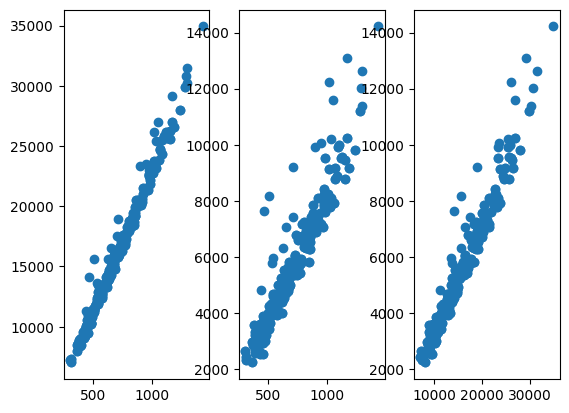

In [ ]:
show_plt(ft, pt, data_in, False, k0)

torch.Size([20, 64, 16, 16])
torch.Size([20, 64, 16, 16])


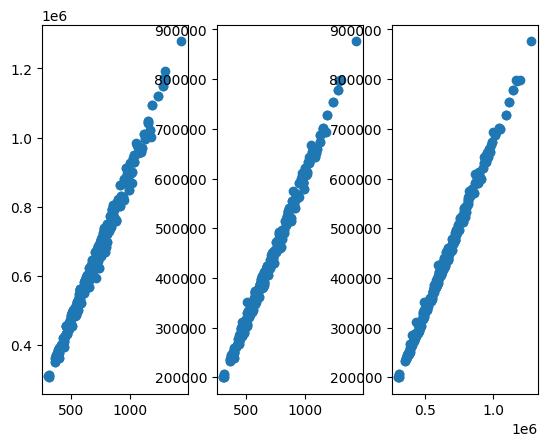

In [ ]:
show_plt(pt1, pt2, data_in, False, k0)

torch.Size([20, 64, 16, 16])
torch.Size([20, 64, 16, 16])


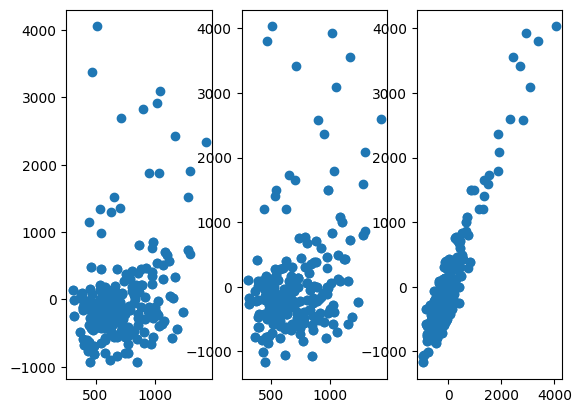

In [ ]:
show_plt(ft, pt, data_in, True, k0)

torch.Size([20, 64, 16, 16])
torch.Size([20, 64, 16, 16])


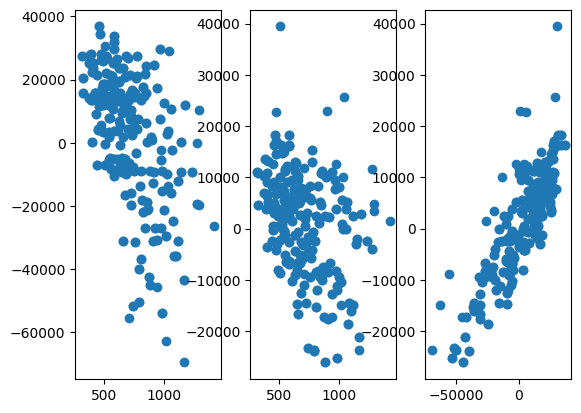

In [ ]:
show_plt(pt1, pt2, data_in, True, k0)

tensor(0.9715, grad_fn=<SelectBackward0>)
tensor([ 0.9715,  0.9310,  0.8306,  0.9174,  0.7164,  0.7482,  0.6033,  0.7272,
         0.5710,  0.4429,  0.3786,  0.4422,  0.2586,  0.0161, -0.0305, -0.0957,
        -0.0969, -0.0346], grad_fn=<DiagonalBackward0>)


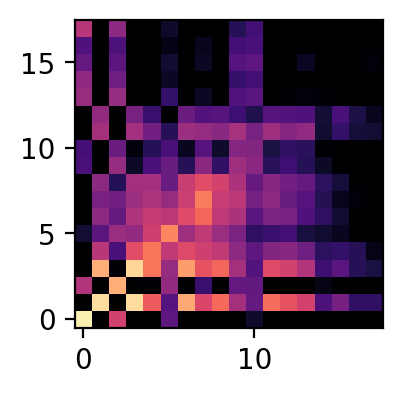

In [ ]:
get_all_layer_outputs_fn(ft)
outputs = ft(data_in)
student_layers_1 = list(activation.values())

get_all_layer_outputs_fn(pt)
outputs = pt(data_in)
student_layers_2 = list(activation.values())

ckamap = compare_activations_batch(student_layers_1, student_layers_2, k0, True)
with torch.no_grad():
  cka_plt(ckamap, 'dcka')
torch.diagonal(ckamap, 0)
a = torch.diagonal(ckamap, 0)
print(a[0])
print(a)

In [ ]:
with torch.no_grad():
    for param in pt1.parameters():
        param.add_(torch.randn(param.size()))
    for param in pt2.parameters():
        param.add_(torch.randn(param.size()))



tensor(0.6965, grad_fn=<SelectBackward0>)
tensor([0.6965, 0.8082, 0.7690, 0.8196, 0.6002, 0.8498, 0.5837, 0.7757, 0.7392,
        0.8224, 0.5961, 0.7193, 0.5631, 0.7402, 0.0962, 0.0719, 0.2831, 0.0643],
       grad_fn=<DiagonalBackward0>)


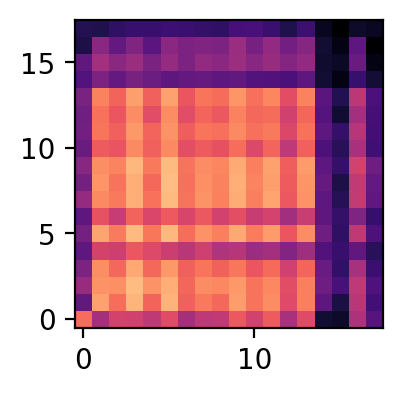

In [ ]:
get_all_layer_outputs_fn(pt1)
outputs = pt1(data_in)
pt1_layers = list(activation.values())

get_all_layer_outputs_fn(pt2)
outputs = pt2(data_in)
pt2_layers = list(activation.values())

ckamap = compare_activations_batch(pt1_layers, pt2_layers, k0, True)
with torch.no_grad():
  cka_plt(ckamap, 'dcka')
a = torch.diagonal(ckamap, 0)
print(a[0])
print(a)

tensor(0.9857, grad_fn=<SelectBackward0>)
tensor([0.9857, 0.9745, 0.9350, 0.8956, 0.7206, 0.7908, 0.6975, 0.7526, 0.5278,
        0.5723, 0.4580, 0.3627, 0.0883, 0.4260, 0.0593, 0.0567, 0.0089, 0.0269],
       grad_fn=<DiagonalBackward0>)


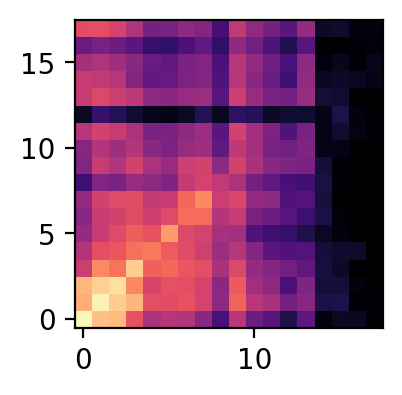

In [ ]:
get_all_layer_outputs_fn(ft)
outputs = ft(data_in)
student_layers_1 = list(activation.values())

get_all_layer_outputs_fn(pt)
outputs = pt(data_in)
student_layers_2 = list(activation.values())

ckamap = compare_activations_batch(student_layers_1, student_layers_2, k0, False)
with torch.no_grad():
  cka_plt(ckamap, 'dcka')
a = torch.diagonal(ckamap, 0)
print(a[0])
print(a)

tensor(0.9981, grad_fn=<SelectBackward0>)
tensor([0.9981, 0.9243, 0.8570, 0.9231, 0.8476, 0.9012, 0.8346, 0.8629, 0.7855,
        0.7958, 0.5621, 0.6598, 0.4879, 0.5889, 0.3134, 0.2899, 0.1761, 0.0067],
       grad_fn=<DiagonalBackward0>)


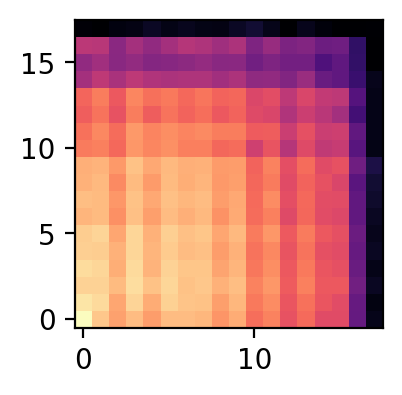

In [ ]:
get_all_layer_outputs_fn(pt1)
outputs = pt1(data_in)
pt1_layaers = list(activation.values())

get_all_layer_outputs_fn(pt2)
outputs = pt2(data_in)
pt2_layers = list(activation.values())

ckamap = compare_activations_batch(pt1_layaers, pt2_layers, k0, False)
with torch.no_grad():
  cka_plt(ckamap, 'dcka')
a = torch.diagonal(ckamap, 0)
print(a[0])
print(a)

In [ ]:
import numpy as np
import tqdm
def HSIC(K, L):
  n = K.shape[0]
  ones = torch.ones((n,1))

  H = torch.eye(n) - torch.ones((n, n)) / n
  hc = 1/((n-1)*(n-1)) * torch.trace(torch.matmul(torch.matmul(K,H), torch.matmul(L,H)))

  return hc